In [1]:
import enoki as ek
import numpy as np
import matplotlib.pyplot as plt
import mitsuba
mitsuba.set_variant('gpu_autodiff_acoustic')
from mitsuba.python.util import traverse
from IPython import display
import time
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

2021-05-13 13:45:43 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [2]:
def pad_first_zeros(arr):
    non_zero = (arr!=0).argmax(axis=0)
    ret = np.copy(arr)
    
    arr_pad = np.copy(arr)
    for i,v in enumerate(non_zero):
        arr_pad[:v,i] = 1
    
    return arr_pad

def estimate_detector_radius(room_dimensions, N):
    return ((15 * room_dimensions[0] * room_dimensions[1] * room_dimensions[2]) / (2 * np.pi * N))**(1/2)

def estimate_max_depth(box_dimensions, max_time, boost=1):
    max_box_distance = np.linalg.norm(box_dimensions) / 2
    max_box_time = max_box_distance / 343
    max_depth_estimate = np.ceil(max_time / max_box_time * boost).astype(int) 
    return max_depth_estimate

def make_shoebox_scene(emitter_pos, sensor_pos, box_dimensions, radius, max_time, time_steps, spp, wavs, max_depth=5, samples_per_pass=1, scattering=0.0,
                       reflectance=0.0, hide_sensor=True):
    from mitsuba.core import ScalarTransform4f

    def transform(scale=None, rotate=None, translate=None):
        if translate is None:
            translate = [0, 0, 0]
        if scale is None:
            scale = [1, 1, 1]
        if rotate is None:
            rotate = ([0, 0, 0], 0)

        a = ScalarTransform4f.scale(scale)
        b = ScalarTransform4f.rotate(*rotate)
        c = ScalarTransform4f.translate(translate)
        return c * b * a

    global_translation = transform(translate=np.array(box_dimensions) / 2)

    scene = {
        "type": "scene",
        "bsdf_neutral": {
            "type": "acousticbsdf",
            "scattering": {
                "type": "acoustic",
                "value": scattering
            },
            "absorption": {
                "type": "spectrum",
#                "type": "acoustic",
#                "absorption": True,
                "value": reflectance
            }
        },
        "emitter_shape": {
            "id": "emitter",
            "type": "sphere",
            "radius": radius,
            "to_world": transform(translate=emitter_pos),
            "emitter": {
                "type": "area",
                "radiance": {
                    "type": "uniform",
                    "value": 1
                }
            }
        },
        "sensor": {
            "type": "microphone",
            "to_world": transform(translate=sensor_pos),
            "sampler": {
                "type": "independent",
                "sample_count": spp
            },
            "myfilm": {
                "type": "tape",
                "time_steps": time_steps,
                "wav_bins": len(wavs)
            }  
        },
        "shoebox": {
            "id": "shoebox_ref",
            "type": "shapegroup",
            "bottom": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    translate=[0, 0, -1]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "left": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([0, 1, 0], 90),
                    translate=[-1, 0, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "back": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([1, 0, 0], 90),
                    translate=[0, 1, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "front": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([1, 0, 0], -90),
                    translate=[0, -1, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "right": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([0, 1, 0], -90),
                    translate=[1, 0, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "top": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([0, 1, 0], 180),
                    translate=[0, 0, 1]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            }
        },
        "shoebox_instance": {
            "type": "instance",
            "shape": {
                "type": "ref",
                "id": "shoebox_ref"
            },
            "to_world": global_translation * transform(scale=np.array(box_dimensions) / 2)
        },
        "integrator": {
            "type": "acousticpath",
            "max_depth": int(max_depth),
            "max_time": max_time,
            "wavelength_bins": ','.join(str(x) for x in wavs),
            "samples_per_pass": samples_per_pass
        }
    }
    return scene

def get_vals(data, time_steps, bin_count):
    return np.array(data, copy=False).reshape([time_steps, bin_count])


def make_integrator(bins, samples_per_pass, max_depth=5, max_time=1.):
    str_bins = list(map(str, bins))
    from mitsuba.core.xml import load_string

    integrator = load_string(f"""
    <integrator version='2.0.0' type='acousticpath'>
        <float name='max_time' value='{max_time}'/>
        <integer name='max_depth' value='{max_depth}'/>
        <string name='wavelength_bins' value='{','.join(str_bins)}'/>
        <integer name='samples_per_pass' value='{samples_per_pass}'/>
    </integrator>
    """)
    assert integrator is not None
    return integrator


In [3]:
from mitsuba.core.xml import load_string, load_dict

bins = np.linspace(0.17, 17, 5)
absorption = [(a, b) for a, b in zip(bins, np.random.uniform(0.01, .5, 5))]
reflectance = [(a, 1 - b) for a, b in absorption]
max_time = 1
time_steps = 10 * max_time
spp = 1000
box_dimensions=[25, 12, 7]
emitter_pos=[20, 7, 2]
sensor_pos=[9, 6, 1]
max_depth_estimate = estimate_max_depth(box_dimensions, max_time, boost=1.5)

scene = load_dict(make_shoebox_scene(emitter_pos=emitter_pos,
                                     sensor_pos=sensor_pos,
                                     box_dimensions=box_dimensions,
                                     radius=estimate_detector_radius(box_dimensions, spp),
                                     max_time=max_time,
                                     time_steps=time_steps,
                                     spp=spp,
                                     wavs=bins,
                                     max_depth=max_depth_estimate,
                                     samples_per_pass=1000,
                                     scattering=0.0,
                                     reflectance=reflectance))


2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/acousticbsdf.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/acoustic.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/irregular.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/sphere.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/area.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/d65.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/regular.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/microphone.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/tape.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/gaussian.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/shapegroup.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/rectangle.so" ..

2021-05-13 13:45:43 INFO main [ShapeKDTree] Building a SAH kd-tree (6 primitives) ..

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] kd-tree configuration:

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Cost model : SurfaceAreaHeuristic3[
2021-05-13 13:45:43 DEBUG main [TShapeKDTree] query_cost = 20,
2021-05-13 13:45:43 DEBUG main [TShapeKDTree] traversal_cost = 15,
2021-05-13 13:45:43 DEBUG main [TShapeKDTree] empty_space_bonus = 0.9
2021-05-13 13:45:43 DEBUG main [TShapeKDTree] ]

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Max. tree depth : 10

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Scene bounding box (min) : [-1, -1, -1]

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Scene bounding box (max) : [1, 1, 1]

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Min-max bins : 128

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] O(n log n) method : use for <= 65536 primitives

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Stopping primitive count : 3

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Perfect splits : yes

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Retract bad splits : yes

2021-05-13 13:45:43 DEBUG main [TShapeKDTree]

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Creating a preliminary index list (24 B)

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Structural kd-tree statistics:

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Primitive references : 6 (24 B)

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] kd-tree nodes : 1 (8 B)

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] kd-tree depth : 0

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Temporary storage used : 5 MiB

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Parallel work units : 1

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Leaf node histogram : 0(0) 1(0) 2(0) 3(0)

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] 4(0) 5(0) 6(1) 7(0)

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] 8(0) 9(0) 10(0) 11(0)

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] 12(0) 13(0) 14(0) 15(0)

2021-05-13 13:45:43 DEBUG main [TShapeKDTree]

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Qualitative kd-tree statistics:

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Retracted splits : 0

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Bad refines : 0

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Pruned : 0

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Largest leaf node : 6 primitives

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Avg. prims/nonempty leaf : 6.00

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Expected traversals/query : 0.00

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Expected leaf visits/query : 1.00

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Expected prim. visits/query : 6.00

2021-05-13 13:45:43 DEBUG main [TShapeKDTree] Final cost : 120.00

2021-05-13 13:45:43 DEBUG main [TShapeKDTree]

2021-05-13 13:45:43 INFO main [ShapeKDTree] Finished. (32 B of storage, took 17ms)

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/instance.so" ..

2021-05-13 13:45:43 INFO main [PluginManager] Loading plugin "plugins/acousticpath.so" ..

2021-05-13 13:45:43 INFO main [Scene] Building scene in OptiX ..

[0.594569, 0.518934, 0.600229, 0.54841, 0.811501]


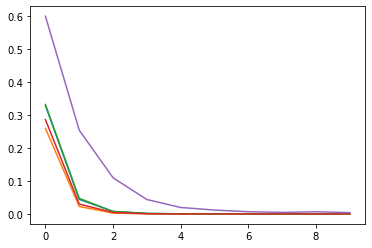

In [4]:
from mitsuba.core import Spectrum

diff_param = 'AcousticBSDF.absorption.values'

params = traverse(scene)
#print(params)
print(params[diff_param])
params.keep([diff_param])
param_ref = Spectrum(params[diff_param])

from mitsuba.python.autodiff import render
hist_ref = render(scene, spp=None)
plt.plot(get_vals(hist_ref, time_steps, len(bins)))

In [5]:
def plot_optimization_state(axs, current, target, bins, max_time=1.0):
    
    ax = axs[0]
    ax2 = axs[1]
    """Plotting"""
    ax.cla()
    ax2.cla()
    
    Z = current
    Z2 = target
    err.append(np.sum(np.square(Z - Z2)) / (Z.shape[1] * Z.shape[0]))
    
    X = np.linspace(0, len(bins), Z.shape[1])
    Y = np.linspace(0, max_time, Z.shape[0])
    X, Y = np.meshgrid(X, Y)


    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap='inferno')
    surf2 = ax.plot_wireframe(X, Y, Z2, alpha=0.5)
    ax2.plot(err)
    ax2.set_title("Error")
    
    def format_fn(tick_val, tick_pos):
        hz = 343.0 / bins[tick_pos]
        return f'{hz:.0f}'

    ax.set_zlim(0, 1)
    ax.set_xticks(np.arange(len(bins)))
    ax.xaxis.set_major_formatter(format_fn)

    ax.set_xlabel('\nFrequency (Hz)', linespacing=3.2)
    ax.set_ylabel('Time (s)')
    ax.view_init(20, 40)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    """Plotting end"""

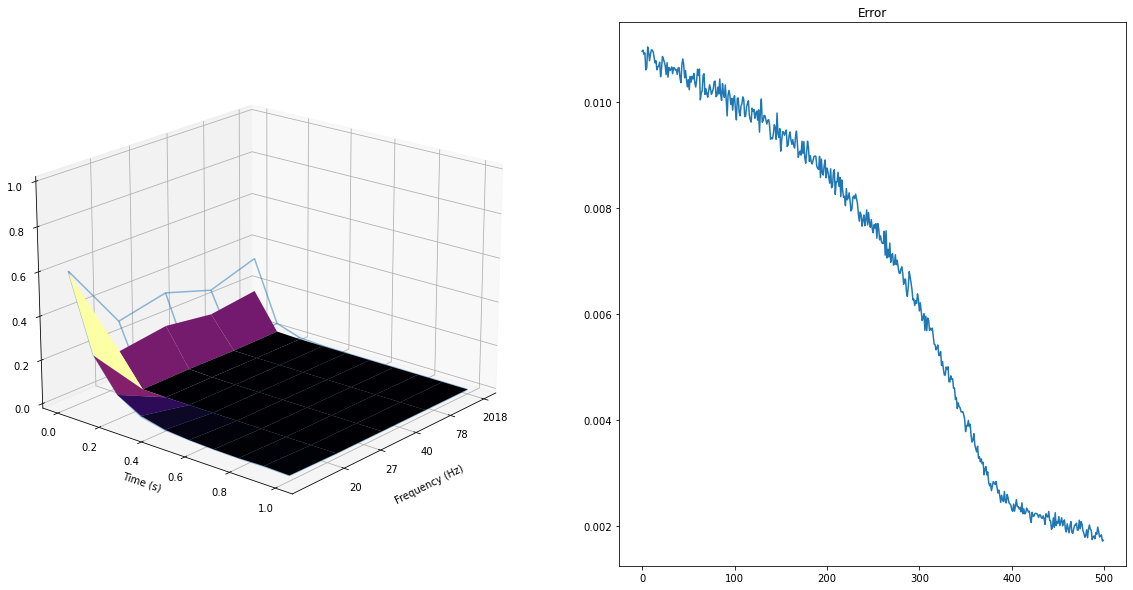

In [6]:
params[diff_param] = [0.1] * len(bins)

iterations = 500

# Construct an optimizer that will adjust the parameters 'params'
from mitsuba.python.autodiff import Adam, SGD
opt = SGD(params, lr=.2)

fig = plt.figure(figsize=(20, 10))
axs = [fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2)]
err = []

    
for it in range(iterations):
    # Perform a differentiable rendering of the scene
    hist = render(scene, optimizer=opt, unbiased=False, spp=None)
    
    np_hist = get_vals(hist, time_steps, len(bins))
    np_hist_ref = get_vals(hist_ref, time_steps, len(bins))
    
    # Objective: MSE between 'hist' and 'hist_ref'
    ob_val = ek.hsum(ek.sqr(hist - hist_ref)) / len(hist)
    
    plot_optimization_state(axs, np_hist, np_hist_ref, bins)

    # Back-propagate errors to input parameters
    ek.backward(ob_val)

    # Optimizer: take a gradient step
    opt.step()
    
    err_ref = ek.hsum(ek.sqr(param_ref - params[diff_param]))
    #print('Iteration %03i: error=%g' % (it, err_ref[0]))